The percentage change in the total energy of the system is 7.113895842438166%
2K + U at start is -1.1422878012145939e+39
2K + U at end is -1.1872642692879932e+38
2K / U at start is -0.000501685691941043
2K / U at 2nd timestep (KE=0 at t=0) is -0.004695180295113023
2K / U at end is -0.940751119567247


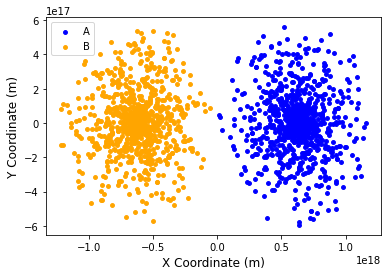

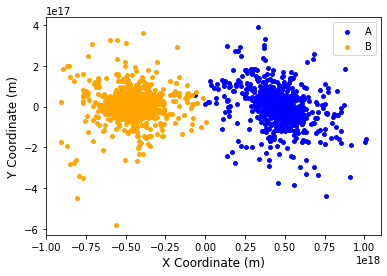

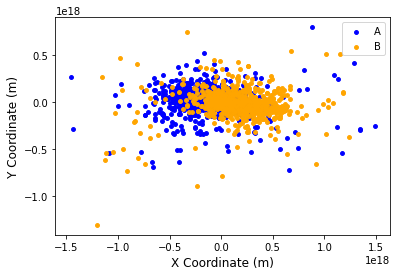

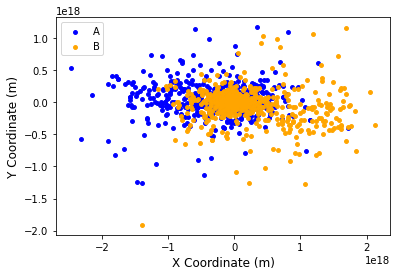

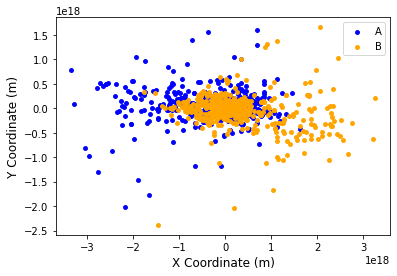

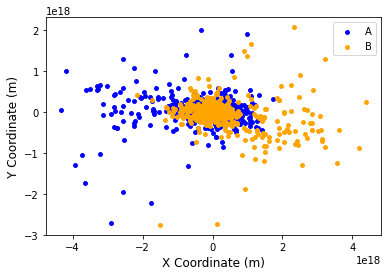

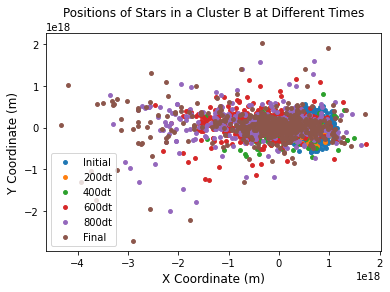

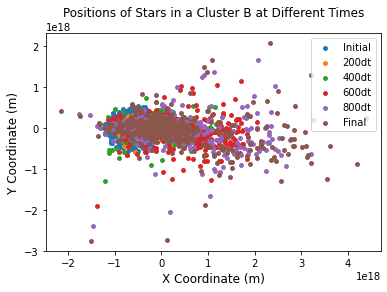

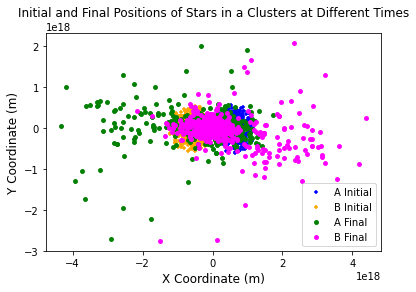

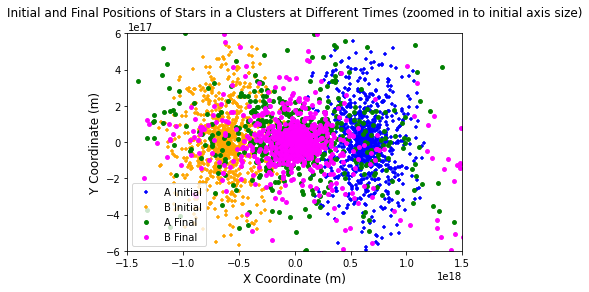

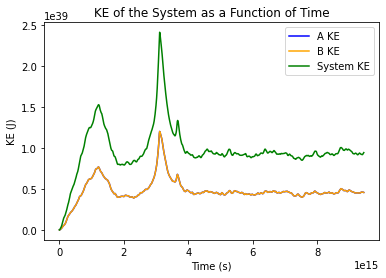

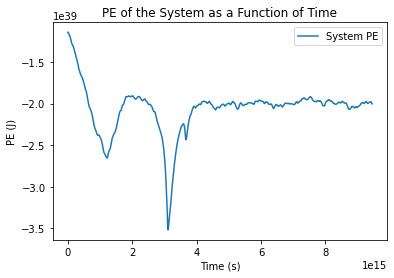

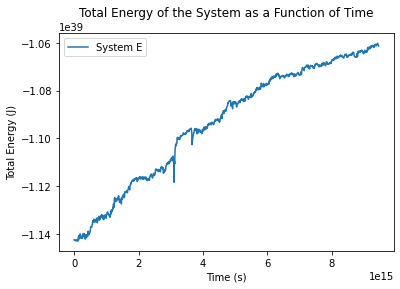

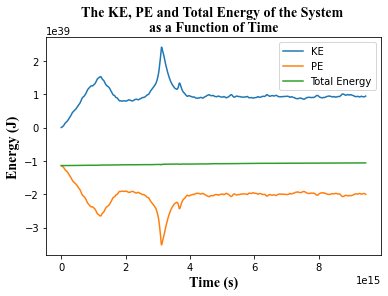

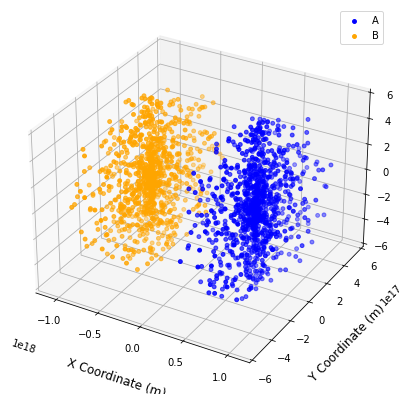

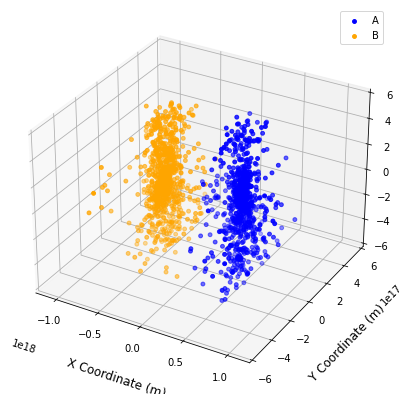

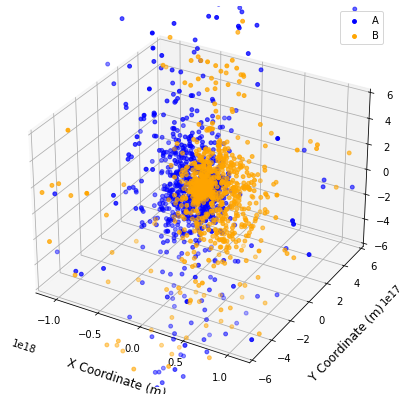

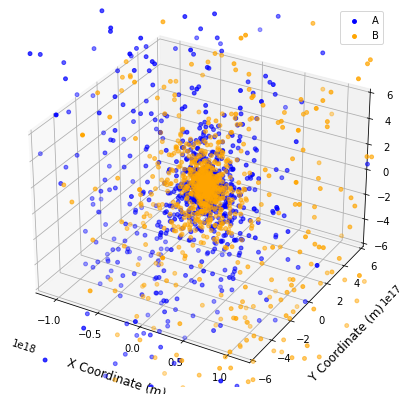

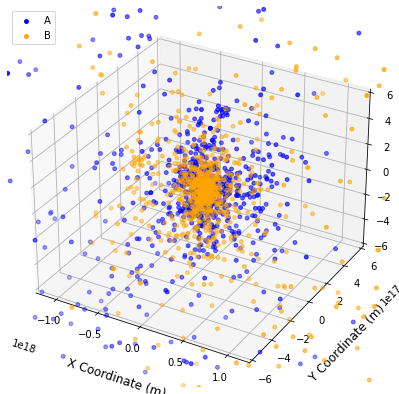

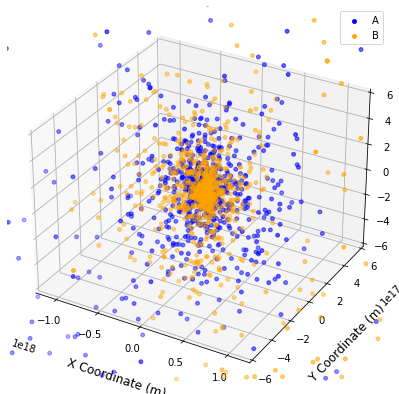

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.animation as animate
from mpl_toolkits import mplot3d

random.seed(1)  # ensures same set of random numbers each time

# constants
G = 6.67 * 10 ** (-11)         # m^3 kg^-1 s^-2
m_sun = 1.9889 * 10 ** 30       # m
pc = 3.09 * 10 ** (16)     # m

n_particles = 1000     # number of particles in per cluster
r_sphere = 20 * pc    # radius of sphere that particles start in
s = 0.01 * r_sphere   # softening factor for force
s_squared = s * s
n_timesteps = 1000
dt = 3 * 10 ** 5 * 365 * 24 * 3600     # trial and error until it seemed to progressively collapse
mass = m_sun
#np.ones((n_particles)) * m_sun   # all same so just keep as constant for now
#masses = [1] * n_particles    # all set to have equal mass - can also do np.ones(n) & multiply by whatever mass I want them all to have

dtbymass = dt / mass

# cluster A & B in one big array
forces = np.zeros((2 * n_particles, 3, n_timesteps))
positions = np.zeros((2 * n_particles, 3, n_timesteps))
velocities = np.zeros((2 * n_particles, 3, n_timesteps + 1))
pe_tot = np.zeros((n_timesteps))

# boundaries
# using spherical coords to get higher density of particles near centre as seen in actual globular clusters
for i in range(0, n_particles):
    r_a = random.random() * r_sphere
    theta_a = random.random() * np.pi
    phi_a = random.random() * 2 * np.pi 
    x_a = r_a * np.sin(theta_a) * np.cos(phi_a) + r_sphere   # separate the two clusters in x direction
    y_a = r_a * np.sin(theta_a) * np.sin(phi_a)
    z_a = r_a * np.cos(theta_a)
    positions[i,:,0] = [x_a,y_a,z_a]

    # spheres homogenous so any straight line position differences can be taken along axis
    r_b = random.random() * r_sphere
    theta_b = random.random() * np.pi
    phi_b = random.random() * 2 * np.pi 
    x_b = r_b * np.sin(theta_b) * np.cos(phi_b) - r_sphere   # separate the two clusters in x direction
    y_b = r_b * np.sin(theta_b) * np.sin(phi_b)
    z_b = r_b * np.cos(theta_b)
    positions[i + n_particles,:,0] = [x_b,y_b,z_b]

# therefore have index 0 - (n_particles - 1) as cluster A 
# and index n_particles - (2 * n_particles - 1) as cluster B
 
def grav_force(mass,positions):
    # separation vectors as NxN matrices of comps x,y,z
    rx_mat = positions[:,0:1] - positions[:,0:1].T
    ry_mat = positions[:,1:2] - positions[:,1:2].T
    rz_mat = positions[:,2:3] - positions[:,2:3].T
    #print(rx_mat,"\n",ry_mat,"\n",rz_mat,"\n")
    #then need to convert this from a NxN to a 1XN
    #print(np.shape(rx_mat))
    mod_sq = np.power(rx_mat,2) + np.power(ry_mat,2) + np.power(rz_mat,2)
    r_sq = (mod_sq + s_squared) ** (1.5)
    fx_mat = - G * mass * mass * rx_mat/r_sq
    fy_mat = - G * mass * mass * ry_mat/r_sq
    fz_mat = - G * mass * mass * rz_mat/r_sq
    force_x = np.sum(fx_mat, axis = 1)
    force_y = np.sum(fy_mat, axis = 1)
    force_z = np.sum(fz_mat, axis = 1)
    force = np.array([force_x, force_y, force_z]).T
    return force


def calc_ke(m, v):
    v_sq_comp = np.power(v, 2)
    v_sq = np.sum(v_sq_comp, axis = 1)
    ke = 0.5 * m * v_sq
    return ke


def calc_pe(mass, positions):
    rx_mat = positions[:,0:1] - positions[:,0:1].T
    ry_mat = positions[:,1:2] - positions[:,1:2].T
    rz_mat = positions[:,2:3] - positions[:,2:3].T
    # don't want to double calc so take upper triangular
    # ii element is already zero and want everything below = 0 --> ,1
    #rx_ut = np.triu(rx_mat,1)
    #ry_ut = np.triu(ry_mat,1)
    #rz_ut = np.triu(rz_mat,1)
    #mod_sq = np.power(rx_ut,2) + np.power(ry_ut,2) + np.power(rz_ut,2)
    mod_sq = np.power(rx_mat, 2) + np.power(ry_mat, 2) + np.power(rz_mat, 2)
    r_sq = np.sqrt(mod_sq + s_squared)
    inv_r = 1/r_sq
    pe = - G * mass * mass * np.sum(np.triu(inv_r), axis = 1)
    return pe

# set initial velocity of cluster B particles so that it collides with cluster A
velocities[n_particles:2*n_particles,:,0] = [170,0,0]

# get initial force for loop
forces[:,:,0] = grav_force(mass, positions[:,:,0])


# initial pe
pe = calc_pe(mass, positions[:,:,0])
pe_tot[0] = np.sum(pe, axis = 0)

# main loop
for i in range(0, n_timesteps - 1): 
    velocities[:,:,i+1] = velocities[:,:,i] + forces[:,:,i] * dtbymass
    positions[:,:,i+1] = positions[:,:,i] + velocities[:,:,i+1] * dt
    forces[:,:,i+1] = grav_force(mass, positions[:,:,i+1])

    # calculate pe
    pe = calc_pe(mass, positions[:,:,i+1])
    pe_tot[i+1] = np.sum(pe)

# calc last v at half timestep after last so ke and pe can be shifted

velocities[:,:,n_timesteps] = velocities[:,:,n_timesteps - 1] + forces[:,:,n_timesteps - 1] * dtbymass

# midpooints of vel so at same time as pos
shift_v = velocities[:,:,:-1] + np.diff(velocities) * 0.5

# find for each cluster so can plot separate energy graphs
shift_v_a = shift_v[0:n_particles,:,:]
shift_v_b = shift_v[n_particles:2*n_particles,:,:]

# calculate ke
ke = calc_ke(mass, shift_v)
ke_tot = np.sum(ke,axis=0)

ke_a = calc_ke(mass, shift_v_a)
ke_tot_a = np.sum(ke_a, axis = 0)

ke_b = calc_ke(mass, shift_v_b)
ke_tot_b = np.sum(ke_a, axis = 0)

# define total energy
e_tot = ke_tot + pe_tot

# define times to plot against
times = np.arange(0, (n_timesteps) * dt, dt)

markersize = 15

e_change_percent = (e_tot[-1] - e_tot[0]) / abs(e_tot[0]) * 100
print(f"The percentage change in the total energy of the system is {e_change_percent}%")

virial0 = 2 * ke_tot[0] + pe_tot[0]
virial_end = 2 * ke_tot[-1] + pe_tot[-1]
print(f'2K + U at start is {virial0}')
print(f'2K + U at end is {virial_end}')

virial_ratio0 = 2 * ke_tot[0] / pe_tot[0]
virial_ratio1 = 2 * ke_tot[1] / pe_tot[1]
virial_ratio_end = 2 * ke_tot[-1] / pe_tot[-1]
print(f'2K / U at start is {virial_ratio0}')
print(f'2K / U at 2nd timestep (KE=0 at t=0) is {virial_ratio1}')
print(f'2K / U at end is {virial_ratio_end}')


# plot data
plt.figure()
plt.xlabel("X Coordinate (m)", fontsize = 12)
plt.ylabel("Y Coordinate (m)",fontsize = 12)
#for i in range(0, n_particles - 1):
plt.scatter(positions[0:n_particles,0:1,0],positions[0:n_particles,1:2,0], s = markersize, label = 'A',color = 'blue')
plt.scatter(positions[n_particles:2*n_particles,0:1,0],positions[n_particles:2*n_particles,1:2,0], s = markersize, label = 'B',color = 'orange')
plt.legend()
plt.savefig("Initial 2D.png", bbox_inches = 'tight', dpi = 800)

#plt.figure(figsize = (5,5))
plt.figure()
plt.xlabel("X Coordinate (m)", fontsize = 12)
plt.ylabel("Y Coordinate (m)",fontsize = 12)
#for i in range(0, n_particles - 1):
plt.scatter(positions[0:n_particles,0:1,200],positions[0:n_particles,1:2,200], s = markersize, label = 'A',color = 'blue')
plt.scatter(positions[n_particles:2*n_particles,0:1,200],positions[n_particles:2*n_particles,1:2,200], s = markersize, label = 'B', color = 'orange')
plt.legend()

#plt.figure(figsize = (5,5))
plt.figure()
plt.xlabel("X Coordinate (m)", fontsize = 12)
plt.ylabel("Y Coordinate (m)",fontsize = 12)
#for i in range(0, n_particles - 1):
plt.scatter(positions[0:n_particles,0:1,400],positions[0:n_particles,1:2,400], s = markersize, label = 'A', color = 'blue')
plt.scatter(positions[n_particles:2*n_particles,0:1,400],positions[n_particles:2*n_particles,1:2,400], s = markersize, label = 'B', color = 'orange')
plt.legend()

#plt.figure(figsize = (5,5))
plt.figure()
plt.xlabel("X Coordinate (m)", fontsize = 12)
plt.ylabel("Y Coordinate (m)",fontsize = 12)
#for i in range(0, n_particles - 1):
plt.scatter(positions[0:n_particles,0:1,600],positions[0:n_particles,1:2,600], s = markersize,label = 'A', color = 'blue')
plt.scatter(positions[n_particles:2*n_particles,0:1,600],positions[n_particles:2*n_particles,1:2,600], s = markersize,label = 'B', color = 'orange')
plt.legend()

#plt.figure(figsize = (5,5))
plt.figure()
plt.xlabel("X Coordinate (m)", fontsize = 12)
plt.ylabel("Y Coordinate (m)",fontsize = 12)
#for i in range(0, n_particles - 1):
plt.scatter(positions[0:n_particles,0:1:,800],positions[0:n_particles,1:2:,800], s = markersize,label = 'A', color = 'blue')
plt.scatter(positions[n_particles:2*n_particles,0:1:,800],positions[n_particles:2*n_particles,1:2:,800], s = markersize,label = 'B', color = 'orange')
plt.legend()

#plt.figure(figsize = (5,5))
plt.figure()
plt.xlabel("X Coordinate (m)", fontsize = 12)
plt.ylabel("Y Coordinate (m)",fontsize = 12)
#for i in range(0, n_particles - 1):
plt.scatter(positions[0:n_particles,0:1,-1],positions[0:n_particles,1:2,-1], s = markersize, label = 'A', color = 'blue')
plt.scatter(positions[n_particles:2*n_particles,0:1,-1],positions[n_particles:2*n_particles,1:2,-1], s = markersize, label = 'B', color = 'orange')
plt.legend()

plt.figure()
plt.xlabel("X Coordinate (m)", fontsize = 12)
plt.ylabel("Y Coordinate (m)",fontsize = 12)
plt.title("Positions of Stars in a Cluster B at Different Times")
#for i in range(0, n_particles - 1):
plt.scatter(positions[0:n_particles,0:1,0],positions[0:n_particles,1:2,0], label = "Initial", s = markersize)
plt.scatter(positions[0:n_particles,0:1,200],positions[0:n_particles,1:2,200], label = "200dt", s = markersize)
plt.scatter(positions[0:n_particles,0:1,400],positions[0:n_particles,1:2,400], label = "400dt", s = markersize)
plt.scatter(positions[0:n_particles,0:1,600],positions[0:n_particles,1:2,600], label = "600dt", s = markersize)
plt.scatter(positions[0:n_particles,0:1,800],positions[0:n_particles,1:2,800], label = "800dt", s = markersize)
plt.scatter(positions[0:n_particles,0:1,-1],positions[0:n_particles,1:2,-1], label = "Final", s = markersize)
plt.legend()
plt.savefig("Positions of Stars in a Cluster A at Different Times.png", bbox_inches = 'tight', dpi = 400)

plt.figure()
plt.xlabel("X Coordinate (m)", fontsize = 12)
plt.ylabel("Y Coordinate (m)",fontsize = 12)
plt.title("Positions of Stars in a Cluster B at Different Times")
#for i in range(0, n_particles - 1):
plt.scatter(positions[n_particles:2*n_particles,0:1,0],positions[n_particles:2*n_particles,1:2,0], label = "Initial", s = markersize)
plt.scatter(positions[n_particles:2*n_particles,0:1,200],positions[n_particles:2*n_particles,1:2,200], label = "200dt", s = markersize)
plt.scatter(positions[n_particles:2*n_particles,0:1,400],positions[n_particles:2*n_particles,1:2,400], label = "400dt", s = markersize)
plt.scatter(positions[n_particles:2*n_particles,0:1,600],positions[n_particles:2*n_particles,1:2,600], label = "600dt", s = markersize)
plt.scatter(positions[n_particles:2*n_particles,0:1,800],positions[n_particles:2*n_particles,1:2,800], label = "800dt", s = markersize)
plt.scatter(positions[n_particles:2*n_particles,0:1,-1],positions[n_particles:2*n_particles,1:2,-1], label = "Final", s = markersize)
plt.legend()
plt.savefig("Positions of Stars in a Cluster B at Different Times.png", bbox_inches = 'tight', dpi = 400)

plt.figure()
plt.xlabel("X Coordinate (m)", fontsize = 12)
plt.ylabel("Y Coordinate (m)",fontsize = 12)
plt.title("Initial and Final Positions of Stars in a Clusters at Different Times")
#for i in range(0, n_particles - 1):
plt.scatter(positions[0:n_particles,0:1,0],positions[0:n_particles,1:2,0], label = "A Initial", s = markersize, marker = '+', color = 'blue')
plt.scatter(positions[n_particles:2*n_particles,0:1,0],positions[n_particles:2*n_particles,1:2,0], label = "B Initial", marker = '+', s = markersize, color = 'orange')
plt.scatter(positions[0:n_particles,0:1,-1],positions[0:n_particles,1:2,-1], label = "A Final", s = markersize, color = 'green')
plt.scatter(positions[n_particles:2*n_particles,0:1,-1],positions[n_particles:2*n_particles,1:2,-1], label = "B Final", s = markersize, color = 'magenta')
plt.legend()
plt.savefig("Initial and Final Positions of Stars in a Clusters at Different Times.png", bbox_inches = 'tight', dpi = 400)

plt.figure()
plt.xlabel("X Coordinate (m)", fontsize = 12)
plt.ylabel("Y Coordinate (m)",fontsize = 12)
plt.title("Initial and Final Positions of Stars in a Clusters at Different Times (zoomed in to initial axis size)")
#for i in range(0, n_particles - 1):
plt.scatter(positions[0:n_particles,0:1,0],positions[0:n_particles,1:2,0], label = "A Initial", s = markersize, marker = '+' , color = 'blue')
plt.scatter(positions[n_particles:2*n_particles,0:1,0],positions[n_particles:2*n_particles,1:2,0], label = "B Initial", s = markersize, marker = '+', color = 'orange')
plt.scatter(positions[0:n_particles,0:1,-1],positions[0:n_particles,1:2,-1], label = "A Final", s = markersize, color = 'green')
plt.scatter(positions[n_particles:2*n_particles,0:1,-1],positions[n_particles:2*n_particles,1:2,-1], label = "B Final", s = markersize, color = 'magenta')
plt.ylim([-6e17, 6e17])
plt.xlim([-1.5e18, 1.5e18])
plt.legend()
plt.savefig("Initial and Final Positions of Stars in a Cluster at Different Times (zoomed).png", bbox_inches = 'tight', dpi = 400)


plt.figure()

plt.plot(times, ke_tot_a, color = 'blue', label = 'A KE')
plt.plot(times, ke_tot_b, color = 'orange', label = 'B KE')
plt.plot(times, ke_tot, color = 'green', label = 'System KE')
plt.title("KE of the System as a Function of Time")
plt.xlabel("Time (s)")
plt.ylabel("KE (J)")
plt.legend()

plt.figure()
''' need to figure out how to separate clusters for this 
plt.plot(times, pe_tot_a, color = 'blue')
plt.plot(times, pe_tot_b, color = 'orange')
'''
plt.plot(times, pe_tot, label = 'System PE')
plt.title("PE of the System as a Function of Time")
plt.xlabel("Time (s)")
plt.ylabel("PE (J)")
plt.legend()

plt.figure()
''' need to figure out how to separate clusters for this 
plt.plot(times, e_tot_a, color = 'blue')
plt.plot(times, e_tot_b, color = 'orange')
'''
plt.plot(times, e_tot, label = 'System E')
plt.title("Total Energy of the System as a Function of Time")
plt.xlabel("Time (s)")
plt.ylabel("Total Energy (J)")
plt.legend()

plt.figure()
plt.plot(times, ke_tot, label = "KE")
plt.plot(times, pe_tot, label = "PE")
plt.plot(times, e_tot, label = "Total Energy")
plt.xlabel("Time (s)", fontsize = 14, fontname="Times New Roman", fontweight = 'bold')
plt.ylabel("Energy (J)",fontsize = 14, fontname="Times New Roman", fontweight = 'bold')
plt.title("The KE, PE and Total Energy of the System \nas a Function of Time", fontsize = 14, fontname="Times New Roman", fontweight = 'bold')

plt.legend()

# 3D graphs attempt
xlim = [-1.2e18,1.2e18]
ylim = [-6e17,6e17]
zlim = [-6e17,6e17]

plt.figure(figsize = (7,7))
ax = plt.axes(projection = '3d')
ax.scatter3D(positions[0:n_particles,0:1,0],positions[0:n_particles,1:2,0],positions[0:n_particles,2:3,0], s = markersize, label = 'A',color = 'blue')
ax.set_xlabel("X Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_ylabel("Y Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_zlabel("Z Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_xlim([0, 1.2e18])
ax.set_ylim(ylim)
ax.set_zlim(zlim)
plt.legend()
plt.savefig("Single Cluster 3D", bbox_inches = 'tight', dpi = 800)

plt.figure(figsize = (7,7))
ax = plt.axes(projection = '3d')
ax.scatter3D(positions[0:n_particles,0:1,0],positions[0:n_particles,1:2,0],positions[0:n_particles,2:3,0], s = markersize, label = 'A',color = 'blue')
ax.scatter3D(positions[n_particles:2*n_particles,0:1,0],positions[n_particles:2*n_particles,1:2,0],positions[n_particles:2*n_particles,2:3,0], s = markersize, label = 'B',color = 'orange')
ax.set_xlabel("X Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_ylabel("Y Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_zlabel("Z Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)
plt.legend()

#plt.savefig("Initial.png", bbox_inches = 'tight', dpi = 500)

plt.figure(figsize = (7,7))
ax = plt.axes(projection = '3d')
ax.scatter3D(positions[0:n_particles,0:1,200],positions[0:n_particles,1:2,200],positions[0:n_particles,2:3,200], s = markersize, label = 'A',color = 'blue')
ax.scatter3D(positions[n_particles:2*n_particles,0:1,200],positions[n_particles:2*n_particles,1:2,200],positions[n_particles:2*n_particles,2:3,200], s = markersize, label = 'B',color = 'orange')
ax.set_xlabel("X Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_ylabel("Y Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_zlabel("Z Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)
plt.legend()

plt.figure(figsize = (7,7))
ax = plt.axes(projection = '3d')
ax.scatter3D(positions[0:n_particles,0:1,400],positions[0:n_particles,1:2,400],positions[0:n_particles,2:3,400], s = markersize, label = 'A',color = 'blue')
ax.scatter3D(positions[n_particles:2*n_particles,0:1,400],positions[n_particles:2*n_particles,1:2,400],positions[n_particles:2*n_particles,2:3,400], s = markersize, label = 'B',color = 'orange')
ax.set_xlabel("X Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_ylabel("Y Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_zlabel("Z Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)
plt.legend()

plt.figure(figsize = (7,7))
ax = plt.axes(projection = '3d')
ax.scatter3D(positions[0:n_particles,0:1,600],positions[0:n_particles,1:2,600],positions[0:n_particles,2:3,600], s = markersize, label = 'A',color = 'blue')
ax.scatter3D(positions[n_particles:2*n_particles,0:1,600],positions[n_particles:2*n_particles,1:2,600],positions[n_particles:2*n_particles,2:3,600], s = markersize, label = 'B',color = 'orange')
ax.set_xlabel("X Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_ylabel("Y Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_zlabel("Z Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)
plt.legend()

plt.figure(figsize = (7,7))
ax = plt.axes(projection = '3d')
ax.scatter3D(positions[0:n_particles,0:1,800],positions[0:n_particles,1:2,800],positions[0:n_particles,2:3,800], s = markersize, label = 'A',color = 'blue')
ax.scatter3D(positions[n_particles:2*n_particles,0:1,800],positions[n_particles:2*n_particles,1:2,800],positions[n_particles:2*n_particles,2:3,800], s = markersize, label = 'B',color = 'orange')
ax.set_xlabel("X Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_ylabel("Y Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_zlabel("Z Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)
plt.legend()

plt.figure(figsize = (7,7))
ax = plt.axes(projection = '3d')
ax.scatter3D(positions[0:n_particles,0:1,-1],positions[0:n_particles,1:2,-1],positions[0:n_particles,2:3,-1], s = markersize, label = 'A',color = 'blue')
ax.scatter3D(positions[n_particles:2*n_particles,0:1,-1],positions[n_particles:2*n_particles,1:2,-1],positions[n_particles:2*n_particles,2:3,-1], s = markersize, label = 'B',color = 'orange')
ax.set_xlabel("X Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_ylabel("Y Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_zlabel("Z Coordinate (m)", fontsize = 12, labelpad = 15)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)
plt.legend()

plt.show()